In [16]:
!pip install wget

Defaulting to user installation because normal site-packages is not writeable


In [17]:
import os,sys

from google.colab import drive
drive.mount('/content/drive')
sys.path.append("/content/drive/My Drive/Collab/collab_v1")
%cd "/content/drive/My Drive/Collab/collab_v1"

ModuleNotFoundError: No module named 'google.colab'

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

#some plotting routines
import plotting

# data processing
import data_higgs as dh

#import the working methods
import tensorflow as tf
print("TensorFlow version ",tf.__version__)

from tensorflow import keras


from tensorflow.keras import Sequential,Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping

TensorFlow version  2.19.0


In [19]:
#--------- globals

# Need to see a large portion of the data before we can build a layer, for
# example half of data n_batches_per_layer =  NBATCH_FRAC * NUM_EXAMPLES / BATCH_SIZE
BATCH_SIZE = 100

# Seed value
# Apparently you may use different seed values at each stage
SEED_VALUE= 10001
# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(SEED_VALUE)
# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(SEED_VALUE)
# 3. Set `numpy` pseudo-random generator at a fixed value
np.random.seed(SEED_VALUE)
# 4. Set `tensorflow` pseudo-random generator at a fixed value
tf.random.set_seed(SEED_VALUE)

In [20]:
#-------- routines

def split_xy(rawdata):
    #split features and labels from data
    #prepare the data => normalizations !

    # split
    data_y=rawdata['hlabel'] # labels only: 0.=bkg, 1.=sig
    data_x=rawdata.drop(['hlabel'], axis=1) # features only

    #now prepare the data
    mu = data_x.mean()
    s = data_x.std()
    dmax = data_x.max()
    dmin = data_x.min()

    # normal/standard rescaling
    #data_x = (data_x - mu)/s

    # scaling to [-1,1] range
    #data_x = -1. + 2.*(data_x - dmin)/(dmax-dmin)

    # scaling to [0,1] range
    data_x = (data_x - dmin)/(dmax-dmin)


    return data_x,data_y

In [21]:
def main(nepoch=10):
      # Training progress and eval results are shown as logging.INFO; so enables it.

    #needs to be done once if the h5 files need to be recreated...
    #dh.download_and_make_data()

    hdata=dh.load_data()
    data_fnames=hdata['feature_names'].to_numpy()[1:] #drop labels
    n_dims=data_fnames.shape[0]
    print ("Entries read {} with feature names {}".format(n_dims,data_fnames))

    x_trn,y_trn=split_xy(hdata['train']) # training sample, should split a fraction for testing
    x_train, x_test,y_train, y_test = train_test_split(x_trn,y_trn,test_size=0.1) # 10% split
    x_val,y_val=split_xy(hdata['valid']) # independent cross-valid sample

    print("Shapes train:{} and test:{}".format(x_train.shape,x_test.shape))

    #plot distributions
    plotting.plot_sig_bkg_from_np_arrays(x_train.to_numpy(),y_train.to_numpy(),data_fnames,logy=False)

    # ready the data for TF
    ds_train = tf.data.Dataset.from_tensor_slices((x_train.to_numpy(),y_train.to_numpy().reshape(-1, 1)))
    ds_train = ds_train.repeat()
    ds_train = ds_train.batch(BATCH_SIZE,drop_remainder=True)

    ds_test = tf.data.Dataset.from_tensor_slices((x_test.to_numpy(),y_test.to_numpy().reshape(-1, 1)))
    ds_test = ds_test.repeat()
    ds_test = ds_test.batch(BATCH_SIZE,drop_remainder=True)

    train_steps=int(x_train.shape[0]/BATCH_SIZE)
    test_steps=int(x_test.shape[0]/BATCH_SIZE)
    print("Steps train:{} and test:{}".format(train_steps,test_steps))


    dnn = Sequential()
    dnn.add(Dense(50, input_dim=n_dims, activation='relu'))
    dnn.add(Dense(50, input_dim=n_dims, activation='relu'))
    dnn.add(Dense(1, activation='sigmoid')) # output layer/value
    plot_model(dnn, to_file='dnn_model.png', show_shapes=True)

    dnn.compile(optimizer=tf.keras.optimizers.Adam(),
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=['accuracy', 'AUC', 'binary_crossentropy'])

    dnn.summary()

    #optional early stopping
    eval_metric = 'AUC'
    earlystop_callback = EarlyStopping(
            mode='max',
            monitor='val_' + eval_metric,
            patience=5,
            min_delta=0.00001,
            verbose=1
        )

    #run the training
    dnn_model_history = dnn.fit(ds_train,
            epochs=nepoch,
            steps_per_epoch=train_steps,
            #callbacks=[earlystop_callback],
            validation_data=ds_test,
            validation_steps=test_steps,
        )

    #plot training history
    print("history values",dnn_model_history.history.keys())
    plotting.plot_history([('DNN model', dnn_model_history),],key='binary_crossentropy')
    plotting.plot_history([('DNN model', dnn_model_history),],key='auc')
    plotting.plot_history([('DNN model', dnn_model_history),],key='accuracy')

    #plot & print results like ROC and score distribution etc...
    y_score=dnn.predict(x_val.to_numpy())[:,0]
    plotting.plot_roc(y_val,y_score)
    plotting.plot_score(y_val,y_score)
    print()
    auc=roc_auc_score(y_val,y_score)
    print("AUC score: {}".format(auc))


Loading /home/luka/school/mp/ml/collab_v1/data/higgs-parsed/higgs-parsed.h5...
Loaded.
Entries read 18 with feature names ['lepton-pT' 'lepton-eta' 'missing-energy' 'jet_1-pt' 'jet_1-eta'
 'jet_2-pt' 'jet_2-eta' 'jet_3-pt' 'jet_3-eta' 'jet_4-pt' 'jet_4-eta'
 'm_jj' 'm_jjj' 'm_lv' 'm_jlv' 'm_bb' 'm_wbb' 'm_wwbb']
Shapes train:(360000, 18) and test:(40000, 18)


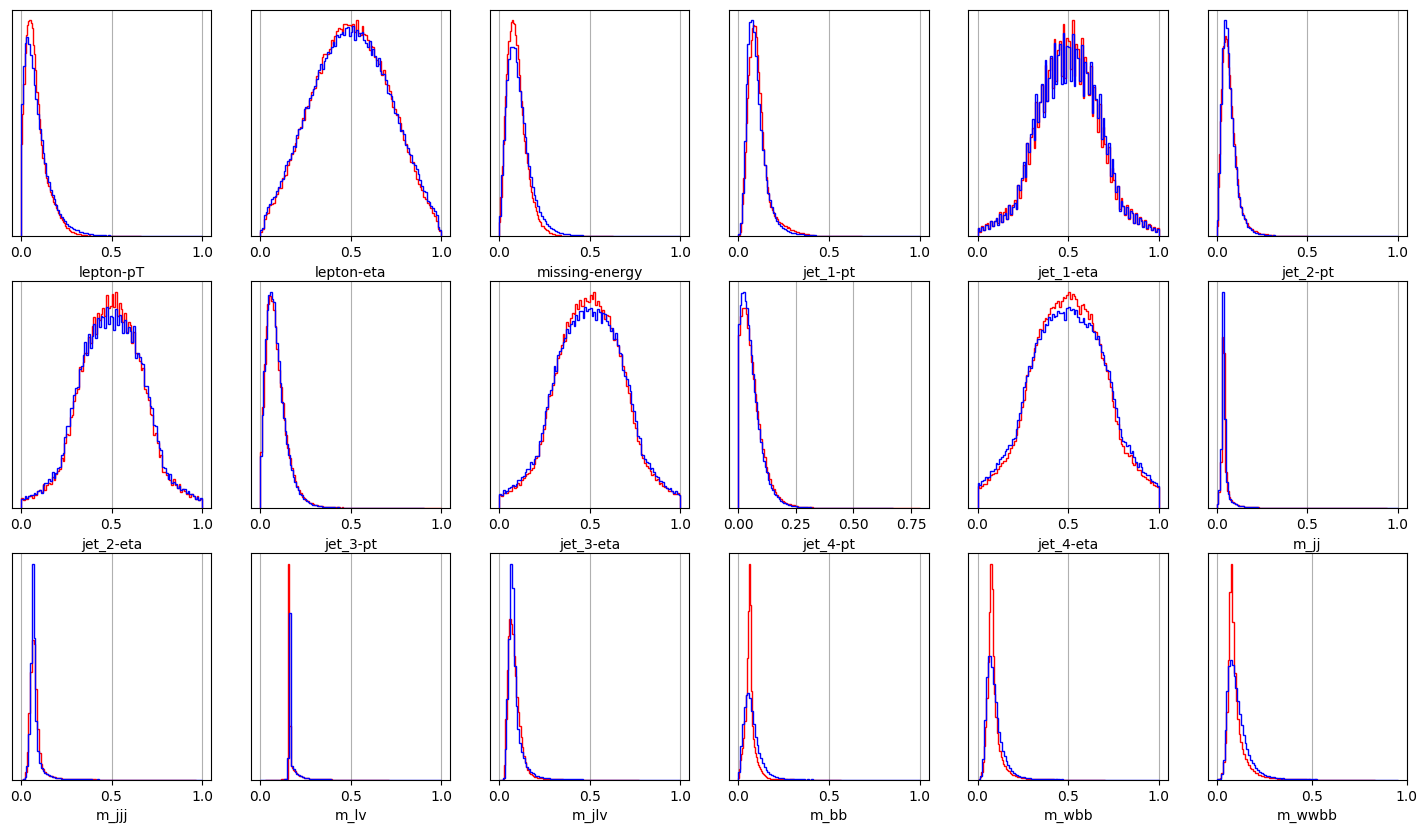

I0000 00:00:1750447444.859789   98737 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1767 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
/home/luka/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Steps train:3600 and test:400
You must install pydot (`pip install pydot`) for `plot_model` to work.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 50)             │           950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,551 (13.87 KB)

 Trainable params: 3,551 (13.87 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/4


I0000 00:00:1750447447.164381   99933 service.cc:152] XLA service 0x7f7c54009720 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750447447.164421   99933 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2025-06-20 21:24:07.209875: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1750447447.404360   99933 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-06-20 21:24:08.870962: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_199', 28 bytes spill stores, 28 bytes spill loads

2025-06-20 21:24:09.132747: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion

  57/3600 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - AUC: 0.4780 - accuracy: 0.5180 - binary_crossentropy: 0.6932 - loss: 0.6932  

I0000 00:00:1750447450.224889   99933 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3600/3600 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - AUC: 0.6350 - accuracy: 0.5991 - binary_crossentropy: 0.6563 - loss: 0.6563 - val_AUC: 0.7101 - val_accuracy: 0.6461 - val_binary_crossentropy: 0.6249 - val_loss: 0.6249
Epoch 2/4
3600/3600 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - AUC: 0.7125 - accuracy: 0.6542 - binary_crossentropy: 0.6175 - loss: 0.6175 - val_AUC: 0.7473 - val_accuracy: 0.6809 - val_binary_crossentropy: 0.5945 - val_loss: 0.5945
Epoch 3/4
3600/3600 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - AUC: 0.7458 - accuracy: 0.6802 - binary_crossentropy: 0.5933 - loss: 0.5933 - val_AUC: 0.7641 - val_accuracy: 0.6926 - val_binary_crossentropy: 0.5794 - val_loss: 0.5794
Epoch 4/4
3600/3600 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - AUC: 0.7598 - accuracy: 0.6924 - binary_crossentropy: 0.5809 - loss: 0.5809 - val_AUC: 0.7729 - val_accuracy: 0.6991 - val_binary_crossentropy: 0.5713 - val_loss: 0.5713
history values dict_keys(['AUC', 'accuracy', 'binary_crossentropy', 'loss', 'val_AUC', 'val_accuracy', 'va

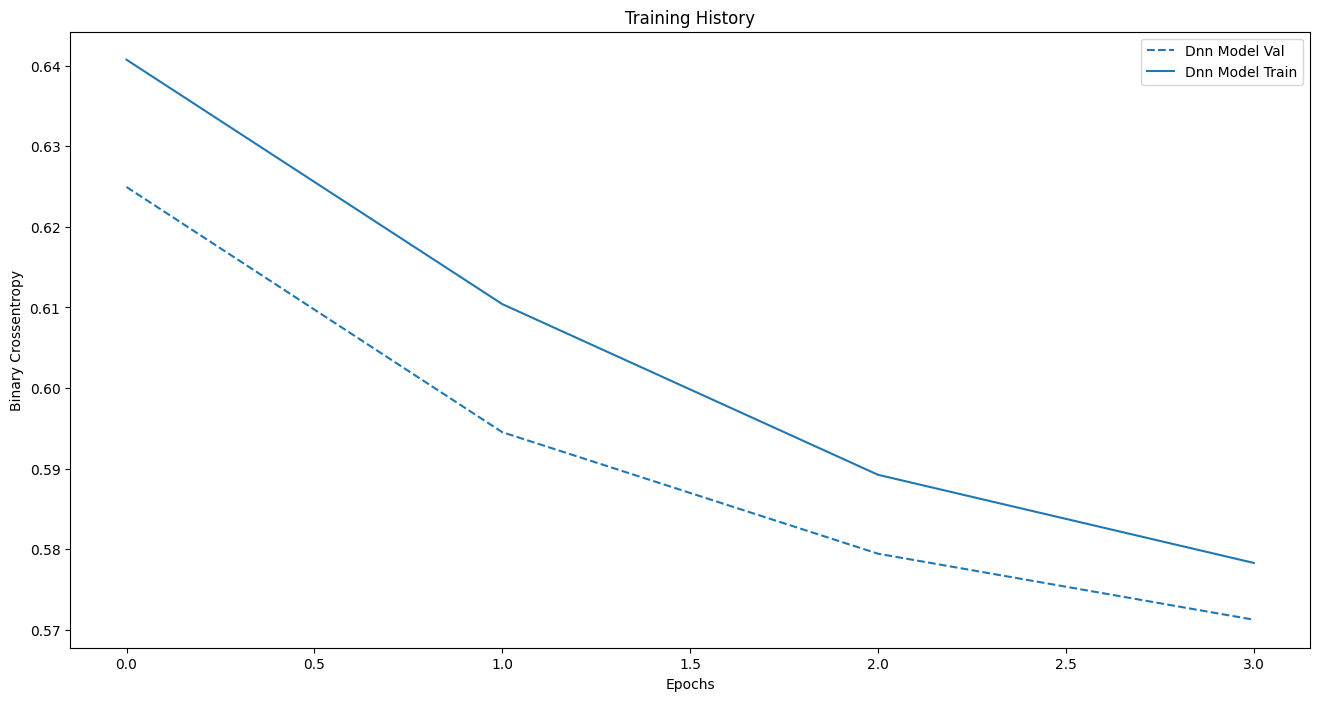

KeyError: 'val_auc'

<Figure size 1600x800 with 0 Axes>

In [22]:
main(4)